# Introduction

This notebook uses little more than 50 variables and 600 observations to try to predict three different age-related conditions. It does some data cleaning, basic exploratory analisys and then fits two models, a neural network and a dicision tree regressor, to make some predictions. The data come from [this](https://www.kaggle.com/competitions/icr-identify-age-related-conditions) kaggle competition.

In [2]:
import numpy as np
import pandas as pd

from sklearn.preprocessing import OneHotEncoder, LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import accuracy_score, f1_score, roc_auc_score

import plotly.express as px
import plotly.graph_objects as go
import seaborn as sns
import matplotlib.pyplot as plt

from scipy.stats import uniform

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)


RANDOM_SEED = 1

In [3]:
greeks = pd.read_csv("/kaggle/input/icr-identify-age-related-conditions/greeks.csv")

display(greeks.head())
display(greeks["Alpha"].value_counts())

,Id,Alpha,Beta,Gamma,Delta,Epsilon
0,000ff2bfdfe9,B,C,G,D,3/19/2019
1,007255e47698,A,C,M,B,Unknown
2,013f2bd269f5,A,C,M,B,Unknown
3,043ac50845d5,A,C,M,B,Unknown
4,044fb8a146ec,D,B,F,B,3/25/2020


Alpha
A    509
B     61
G     29
D     18
Name: count, dtype: int64

In [4]:
ohe = OneHotEncoder(sparse_output=False)
y = ohe.fit_transform(greeks["Alpha"].to_numpy().reshape((-1, 1)))

# Invert bool so that first class is positive when there is age-related condition
y[:, 0] = (~y[:, 0].astype(bool)).astype(float)

In [5]:
df = pd.read_csv("/kaggle/input/icr-identify-age-related-conditions/train.csv")

X = df.drop(["Id", "Class"], axis=1)

## Ajuste dos dados
Primeiro, vou ajustar os tipos de alguns dados, criar uma variável indicadora de valores faltantes e imputar valores aos valores faltantes na base.

In [6]:
print(X["EJ"].value_counts())

le = LabelEncoder().fit(X["EJ"])
X["EJ"] = le.transform(X["EJ"])

print(X["EJ"].value_counts())

EJ
B    395
A    222
Name: count, dtype: int64
EJ
1    395
0    222
Name: count, dtype: int64


Mudando a coluna  de posição para ficar ao final do df

In [7]:
EJ = X["EJ"]
X = X.drop("EJ", axis=1).assign(EJ=EJ)

## Missing value columns

Two columns have plenty of missing values. Creating two boolean columns accounting for this missing data may help the models.

In [8]:
print("Missing values for column 'BQ':", X["BQ"].isna().sum())
print("Missing values for column 'EL':", X["EL"].isna().sum())

X["is_missing_BQ"] = X["BQ"].isna()
X["is_missing_EL"] = X["EL"].isna()

print(X[["is_missing_BQ", "is_missing_EL"]].sum(axis=1).value_counts().sort_index())

Valores faltantes para coluna 'BQ': 60
Valores faltantes para coluna 'EL': 60
Muitas vezes, essas duas colunas tem dados faltantes ao mesmo tempo. Algumas vezes, apenas um ou outro.
0    550
1     14
2     53
Name: count, dtype: int64


## Train test split
Usually I would create a validatin split as well, but since we have little data, I'll use Cross Validation. Other solutions could be creating syntetic data or doing some data upsampling.

In [ ]:
train_size = .7
test_size = .3


X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=test_size, 
                                                    random_state=RANDOM_SEED, 
                                                    stratify=greeks["Alpha"])

## Evaluatin which values to fill empty cells with
Many columns have just a couple of missing values. Since the data base is too small, we can't just get rid of these observations. So, I'll take a look at these variables distributions to decide which value to fill them with, either max, min, median, average or others.

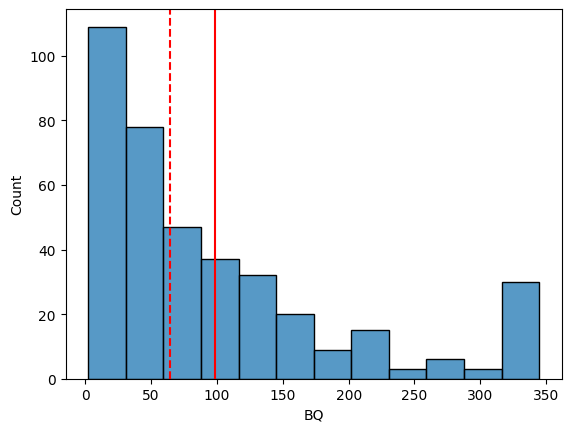

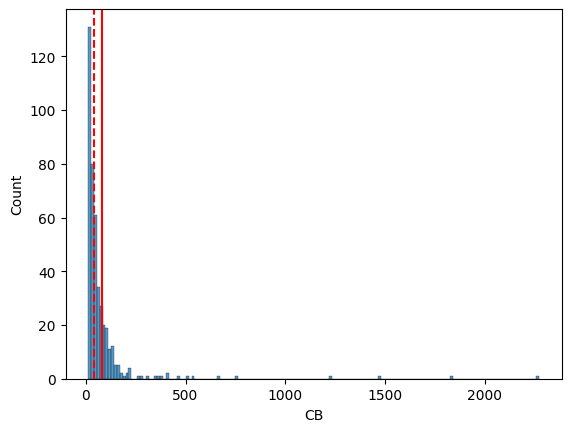

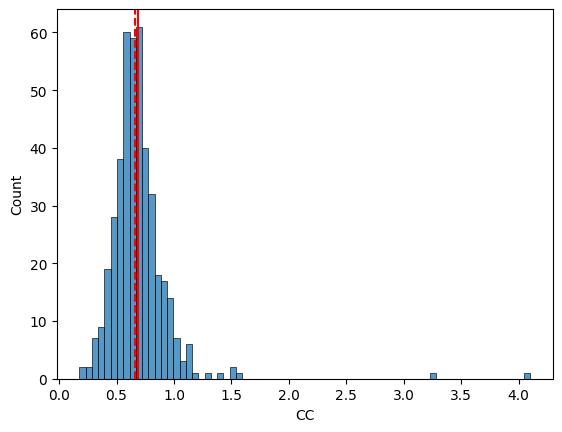

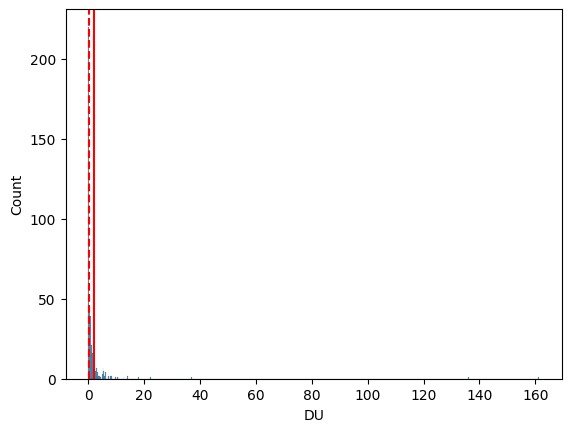

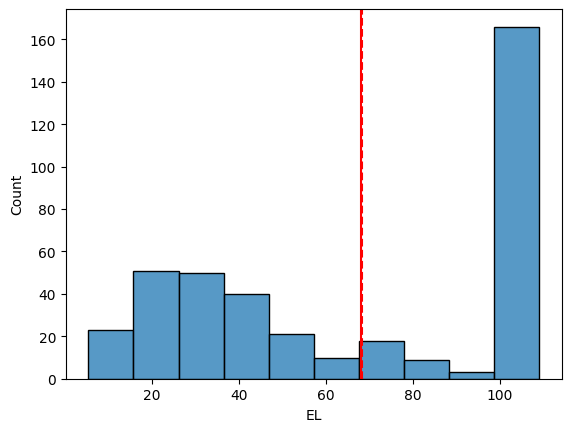

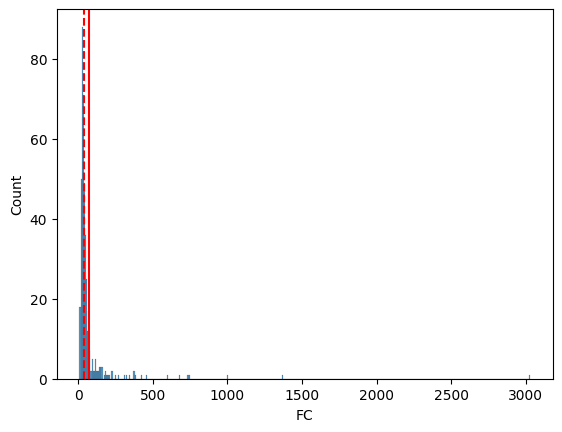

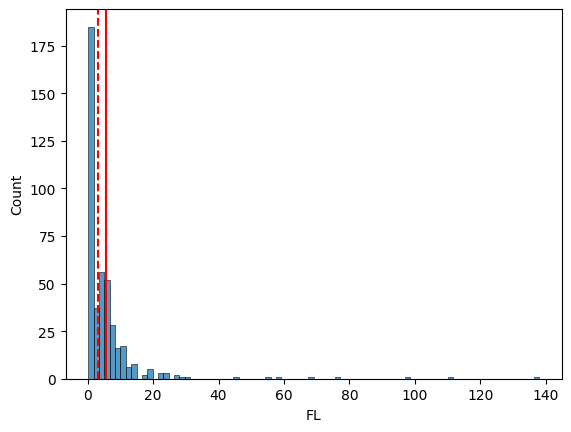

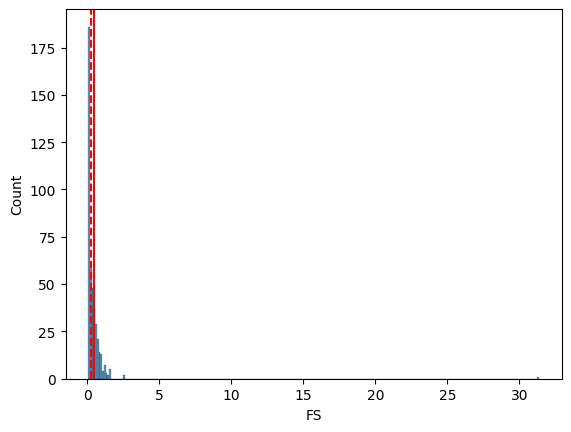

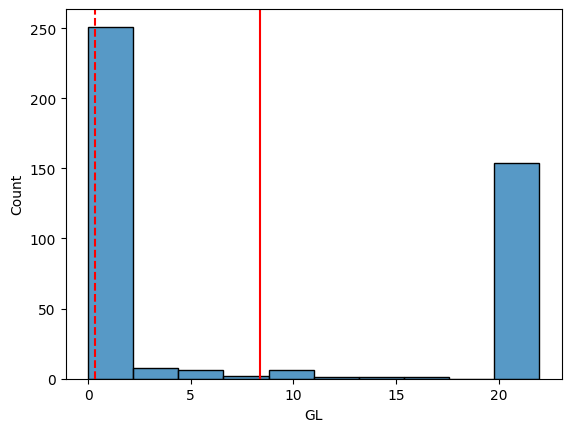

In [10]:
has_missing_value = X.isna().sum(axis=0).astype(bool)
missing_value_columns = has_missing_value[has_missing_value].index

for col in missing_value_columns:
    fig = sns.histplot(X_train, x=col)
    
    mean = X_train[col].mean()
    median = X_train[col].median()
    
    fig.axvline(x=mean, color="red")
    fig.axvline(x=median, color="red", linestyle='dashed')
    
    plt.show()

In [11]:
valores_a_imputar = {
    "BQ": "median",
    "CB": "min",
    "CC": "mean",
    "DU": "median",
    "EL": "max",
    "FC": "median",
    "FL": "min",
    "FS": "min",
    "GL": "min"
}

missing_value_fill = X_train.agg(valores_a_imputar)

In [12]:
for col, val in missing_value_fill.items():
    X_train[col].fillna(val, inplace=True)
for col, val in missing_value_fill.items():
    X_test[col].fillna(val, inplace=True)

## Basic stats

Scales are considerably diferent. Depending on the models, such as neural networks, we must normalize the data.

In [13]:
X_train.describe().T

,count,mean,std,min,25%,50%,75%,max
AB,431.0,0.479047,0.486770,0.081187,0.258517,0.363205,0.564036,6.161666
AF,431.0,3518.291413,2329.421314,192.593280,2193.381520,3124.575740,4394.271090,28688.187660
AH,431.0,119.874546,126.173771,85.200147,85.200147,85.200147,108.553331,1910.123198
AM,431.0,41.411827,75.944926,3.177522,12.333803,20.703445,41.885376,630.518230
AR,431.0,9.960564,9.226583,8.138688,8.138688,8.138688,8.138688,173.534448
AX,431.0,5.448470,2.203397,0.699861,4.097288,5.014194,6.387339,17.983770
AY,431.0,0.064590,0.496646,0.025578,0.025578,0.025578,0.033190,10.315851
AZ,431.0,10.769277,4.332540,3.396778,8.293432,10.518038,13.168029,38.971568
BC,431.0,8.306256,71.552605,1.229900,1.229900,1.229900,5.300869,1463.693448
BD,431.0,5391.718664,3314.248101,1693.624320,4189.164990,5022.410130,6036.001555,53060.599240


## Outliers

I'll consider to be an outlier values more than four standard deviations away from the mean. Transform outlier into column average hurt model performance, so I'll not deal with them for now. Ideal scenario would be to take a closer look to each outlier individually.

In [14]:
total_de_ourliers = 0
for col in X.drop(["EJ", "is_missing_BQ", "is_missing_EL"], axis=1).columns:
    m = X_train[col].mean()
    std = X_train[col].std()
    
    is_outlier = (m - 4*std > X_train[col]) | (X_train[col] > m + 4*std)
    total_de_ourliers += is_outlier.sum()
    
    is_outlier = (m - 4*std > X_test[col]) | (X_test[col] > m + 4*std)
    total_de_ourliers += is_outlier.sum()
    
print(f"There are {total_de_ourliers} outliers, or {total_de_ourliers/X.shape[1]:.2f} outliers ina verage per column")

Existem 195 outliers na base, ou 3.36 outliers em média por coluna


## Correlation map

<Axes: >

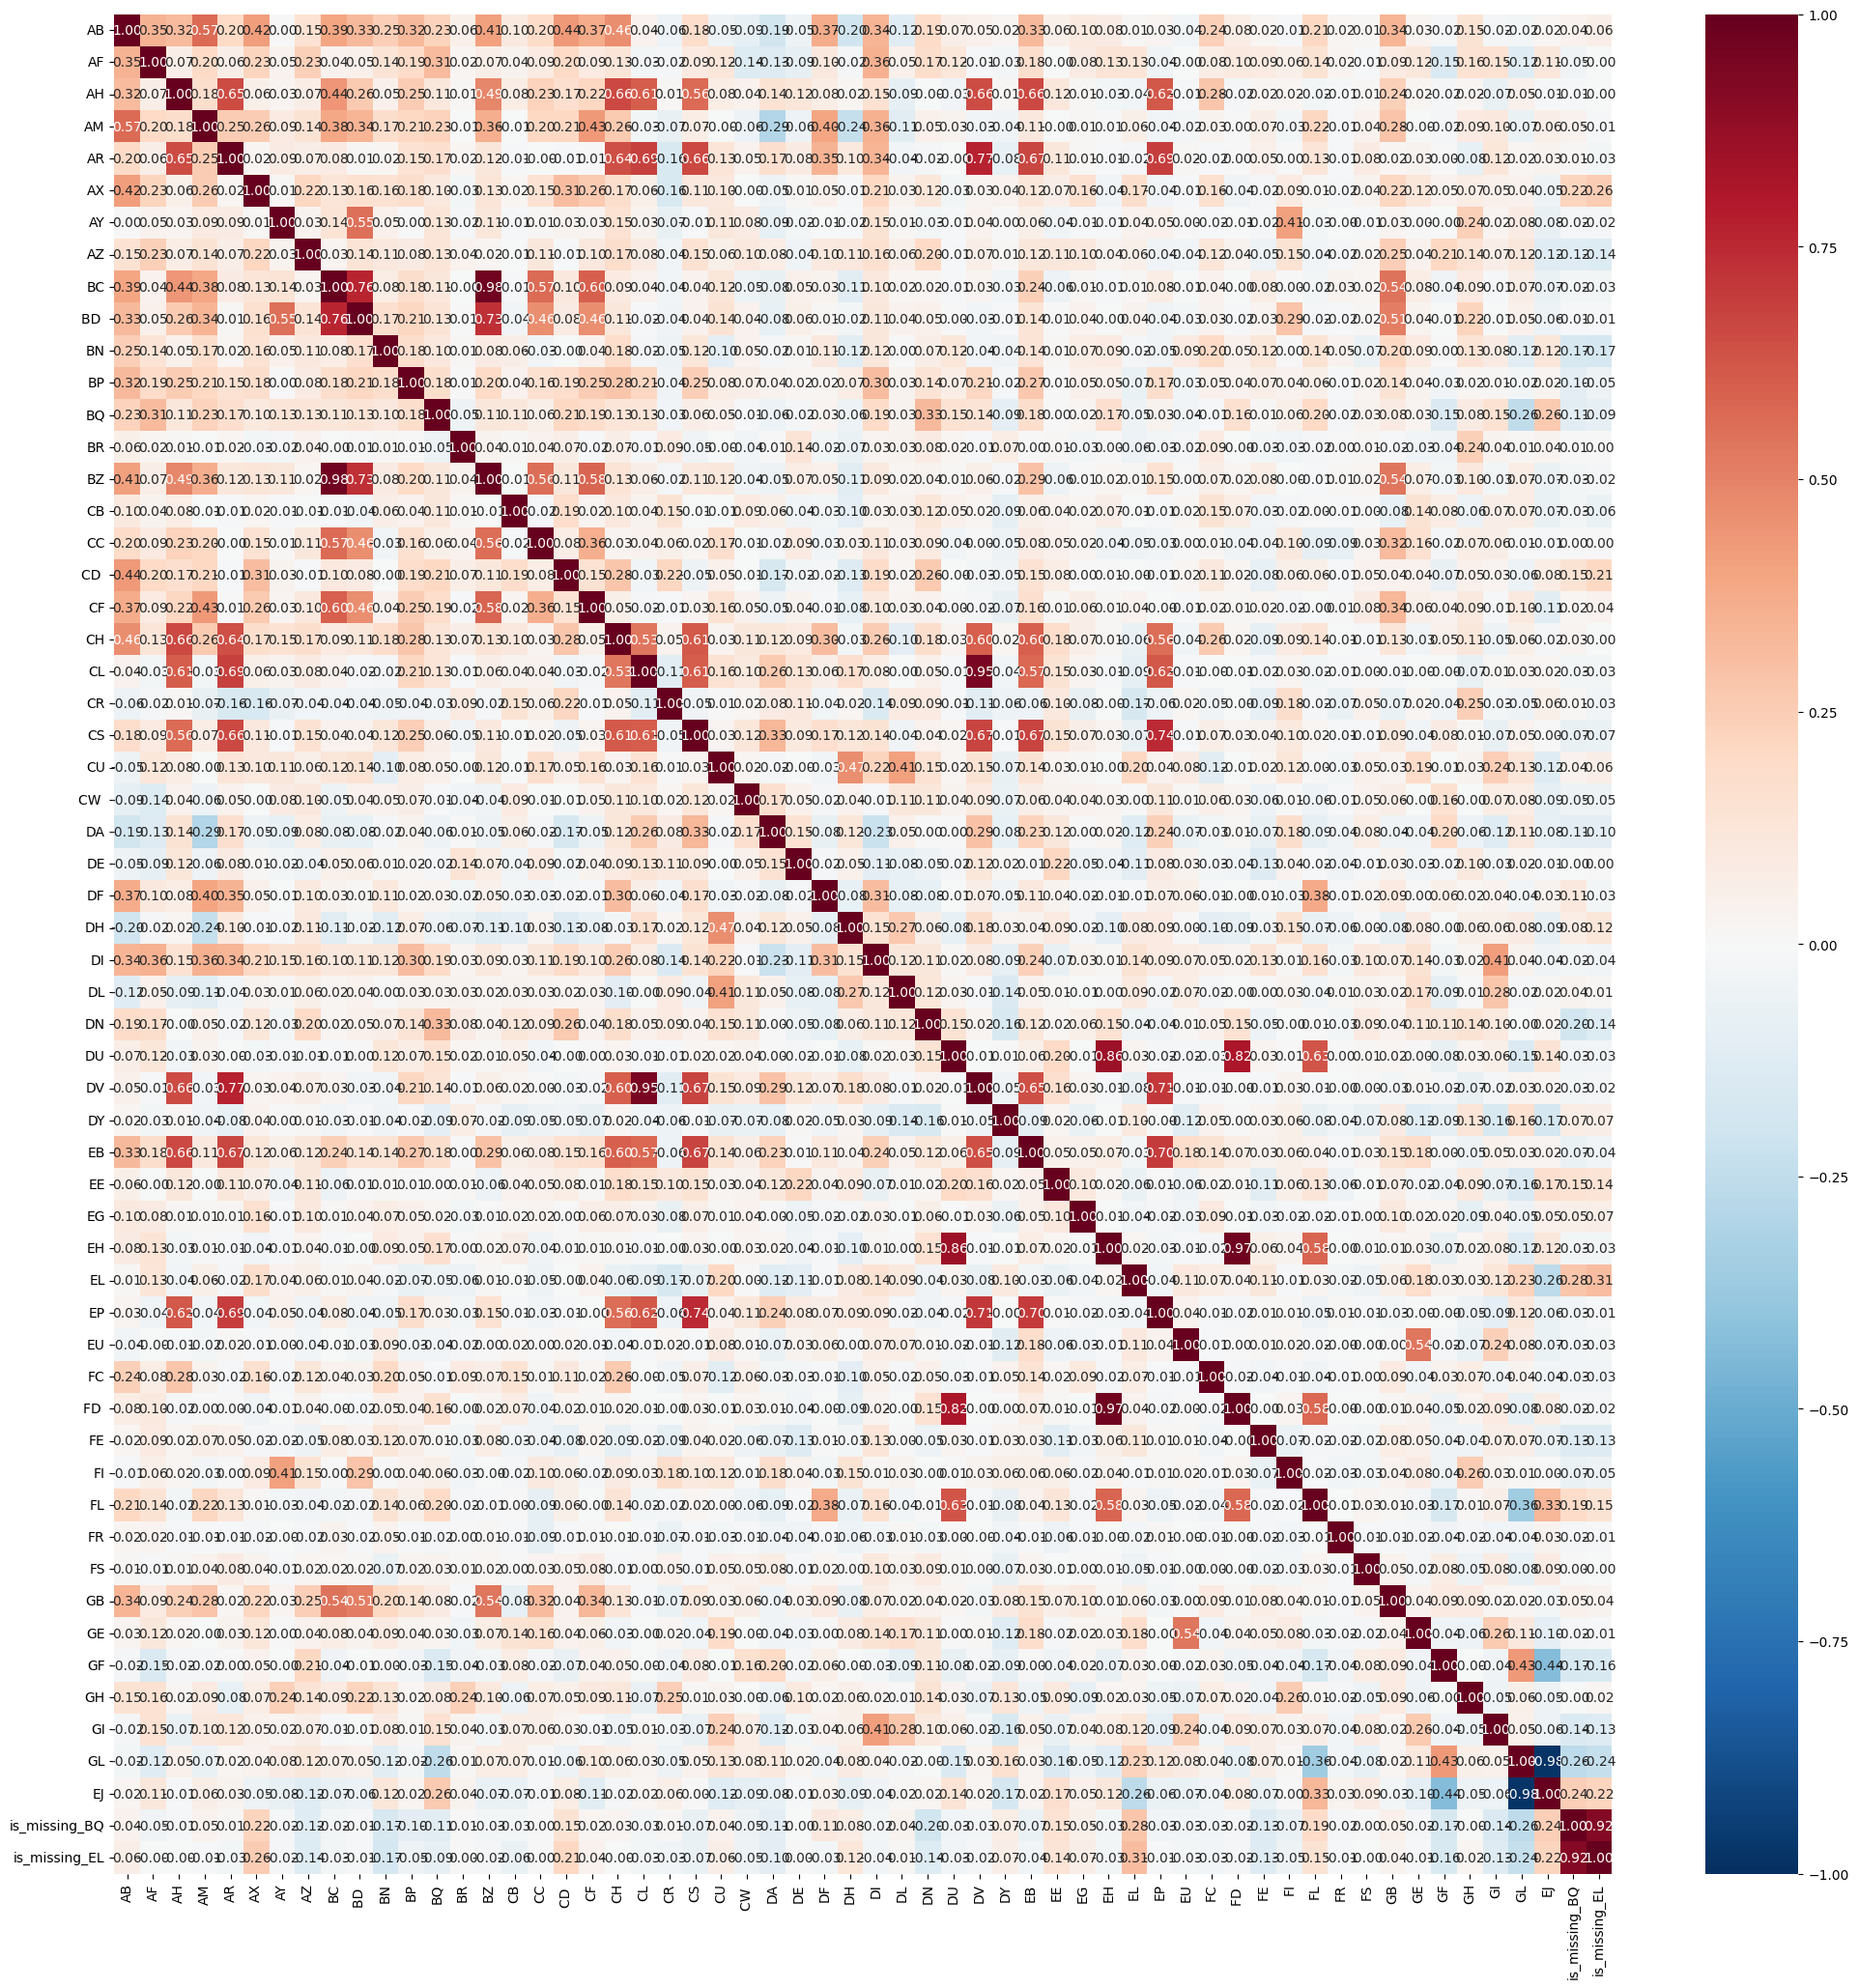

In [15]:
corr_df = X_train.corr()

plt.figure(figsize=(25,25))
sns.heatmap(corr_df, vmin=-1, vmax=1, cmap="RdBu_r", fmt=".2f", annot=True)

Existem algumas variáveis com alta e altíssima correlação dois a dois.
There are a few variables with very high correalation two by two.

Besided that, some variables have tailed distributions, and for this reason I apply a log transformation to make data more well behaved.

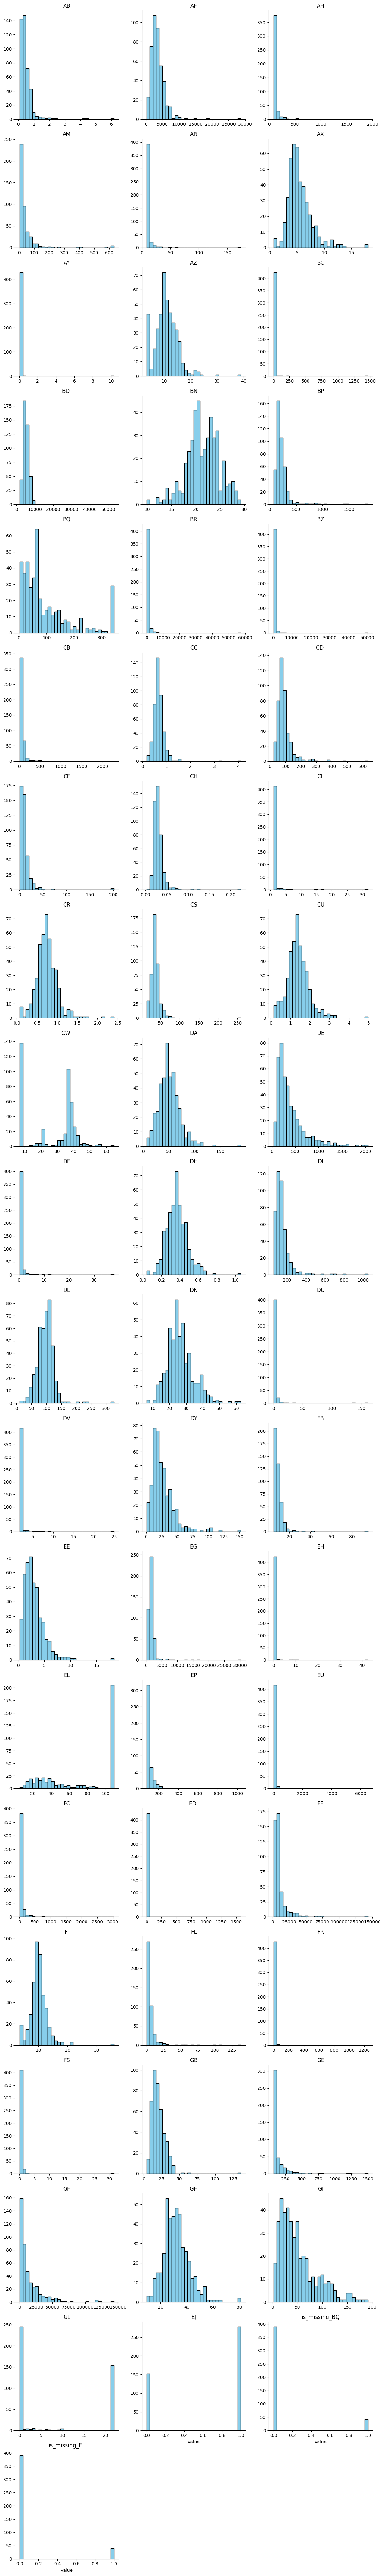

In [16]:
warnings.simplefilter(action='ignore', category=RuntimeWarning)

melted = pd.melt(X_train)

fig = sns.FacetGrid(melted, col="variable", col_wrap=3, height=4, sharex=False, sharey=False)
fig.map(plt.hist, "value", bins=30, color="skyblue", edgecolor="black")

for ax, title in zip(fig.axes.flatten(), X_train.columns):
    ax.set_title(title)

plt.tight_layout()
plt.savefig("/kaggle/working/histogramas.png", dpi=600)

warnings.simplefilter(action='default', category=RuntimeWarning)

In [17]:
variaveis_a_aplicar_log = [
    "AH",
    "AM",
    "AR",
    "AY",
    "BC",
    "BQ",
    "BR",
    "BZ",
    "CB",
    "CF",
    "CL",
    "DE",
    "DF",
    "DU",
    "DV",
    "EB",
    "EH",
    "EP",
    "EU",
    "FC",
    "FD ",
    "FR",
    "FS",
    "GE",
    "GF",
    
]

X_train[variaveis_a_aplicar_log] = np.log(X_train[variaveis_a_aplicar_log])
X_test[variaveis_a_aplicar_log] = np.log(X_test[variaveis_a_aplicar_log])

These variables are too concentrated around a single value and do not add much information. I'll get rid of these, and also of some highly correlated columns

In [18]:
colunas_para_dropar = [
    "DV",
    "GL",
    "FD ",
    "DV",
    "BZ"
]

X_train.drop(colunas_para_dropar, axis=1, inplace=True)
X_test.drop(colunas_para_dropar, axis=1, inplace=True)

Some variables have many repeated values, as can be seen below. Their distribution would be well modeled as a Bernouli times the distribution of the rest of the data. This could be done by creating a Boolean column indicating whether the value is the one that is repeated, and sampling new values based on the rest of the data.

In [19]:
variaveis_com_mtos_valores_repetidos = [
    "AH",
    "AR",
    "AY",
    "BC",
    "CW ",
    "DF",
    "DU",
    "EH",
    "EL",
    "EP",
    "EU",
    "FS",
    "GE"
]

for col in variaveis_com_mtos_valores_repetidos:
    moda = X_train[col].mode()[0]
    ocorrencias = X_train[col].value_counts()[moda]
    print(f"A coluna {col} tem o valor {moda:.3f} repetido {ocorrencias} vezes, ou {ocorrencias / len(X_train)*100:.2f}% do dataframe")

A coluna AH tem o valor 4.445 repetido 275 vezes, ou 63.81% do dataframe
A coluna AR tem o valor 2.097 repetido 346 vezes, ou 80.28% do dataframe
A coluna AY tem o valor -3.666 repetido 301 vezes, ou 69.84% do dataframe
A coluna BC tem o valor 0.207 repetido 240 vezes, ou 55.68% do dataframe
A coluna CW  tem o valor 7.031 repetido 138 vezes, ou 32.02% do dataframe
A coluna DF tem o valor -1.433 repetido 339 vezes, ou 78.65% do dataframe
A coluna DU tem o valor -5.200 repetido 153 vezes, ou 35.50% do dataframe
A coluna EH tem o valor -5.795 repetido 153 vezes, ou 35.50% do dataframe
A coluna EL tem o valor 109.125 repetido 206 vezes, ou 47.80% do dataframe
A coluna EP tem o valor 4.363 repetido 223 vezes, ou 51.74% do dataframe
A coluna EU tem o valor 1.342 repetido 105 vezes, ou 24.36% do dataframe
A coluna FS tem o valor -2.692 repetido 126 vezes, ou 29.23% do dataframe
A coluna GE tem o valor 4.285 repetido 250 vezes, ou 58.00% do dataframe


# Predictions

Now, let's test some models. I will test two: RandomForestClassifier and a neural network. As there are three different health conditions, the idea is to train a model for each, and assign class 1 to the observation if any of these models returns positive. As the base is unbalanced, I will assign weight to each observation a value proportional to its frequency.

## RandomForestBagging

In [20]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier

In [21]:
params = {
    "n_estimators": [50,100,200],
    "max_depth": [5, 10, 20],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 5],
    "max_features": [.2, .5, .8, 1.],
}

preds = np.zeros((y_test.shape[0], 3))
for age_condition_idx in [1,2,3]:
    y_age_condition_train = y_train[:, age_condition_idx]
    y_age_condition_test = y_test[:, age_condition_idx]
    
    # Peso das classes é o inverso da frequência no dataset
    class_weight = {class_: y_age_condition_train.shape[0]/sum(y_age_condition_train == class_) for class_ in [0,1]}
    rfc = RandomForestClassifier(class_weight=class_weight, random_state=RANDOM_SEED)

    clf = RandomizedSearchCV(rfc, params, random_state=RANDOM_SEED, n_iter=10)
    search = clf.fit(X_train, y_age_condition_train)
    
    pred = search.predict(X_test)
    preds[:, age_condition_idx-1] = pred

    print("Age condition idx:", age_condition_idx)
    print("Acc:", accuracy_score(pred, y_age_condition_test))
    print("f1-score:", f1_score(pred, y_age_condition_test))
    try:
        print("ROC AUC:", roc_auc_score(pred, y_age_condition_test))
    except ValueError:
        print("ROC AUC: N/A")
    print()

Age condition idx: 1
Acc: 0.956989247311828
f1-score: 0.75
ROC AUC: 0.9111295681063124

Age condition idx: 2
Acc: 0.9731182795698925
f1-score: 0.0
ROC AUC: N/A

Age condition idx: 3
Acc: 0.9731182795698925
f1-score: 0.6666666666666667
ROC AUC: 0.9055555555555557



In [22]:
pred = preds.sum(axis=1).astype(bool).astype(float)

print("Final")
print("Acc:", accuracy_score(pred, y_test[:, 0]))
print("f1-score:", f1_score(pred, y_test[:, 0]))
print("ROC AUC:", roc_auc_score(pred, y_test[:, 0]))

Final
Acc: 0.9247311827956989
f1-score: 0.7307692307692308
ROC AUC: 0.935843373493976


In [23]:
class_weight = {class_: y_train[:, 0].shape[0]/sum(y_train[:, 0] == class_) for class_ in [0,1]}
rfc = RandomForestClassifier(class_weight=class_weight)

clf = RandomizedSearchCV(rfc, params, random_state=RANDOM_SEED, n_iter=10)
search = clf.fit(X_train, y_train[:, 0])

pred = search.predict(X_test)

print("Acc:", accuracy_score(pred, y_test[:, 0]))
print("f1-score:", f1_score(pred, y_test[:, 0]))
print("ROC AUC:", roc_auc_score(pred, y_test[:, 0]))
print()

Acc: 0.946236559139785
f1-score: 0.8214285714285714
ROC AUC: 0.951388888888889



## Rede neural

In [101]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

In [102]:
class Modelo(nn.Module):
    def __init__(self, n_feats):
        super(Modelo, self).__init__()
        
        self.network = nn.Sequential(
            nn.Linear(n_feats, 512),
            nn.ReLU(),
            nn.Dropout(.5),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Dropout(.5),
            nn.Linear(512, 1),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        outputs = self.network(x)
        return outputs
    
model = Modelo(X_train.shape[1]).to("cpu")
model

Modelo(
  (network): Sequential(
    (0): Linear(in_features=54, out_features=512, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in_features=512, out_features=512, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.5, inplace=False)
    (6): Linear(in_features=512, out_features=1, bias=True)
    (7): Sigmoid()
  )
)

In [103]:
bce_loss = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=.5e-3)

In [104]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=.2, random_state=RANDOM_SEED, stratify=y_train)

X_train_float = X_train.apply(lambda x: x.astype(float), axis=1)
X_val_float = X_val.apply(lambda x: x.astype(float), axis=1)
X_test_float = X_test.apply(lambda x: x.astype(float), axis=1)


for col in X_train_float.columns:
    q02 = X_train_float[col].quantile(.02)
    q98 = X_train_float[col].quantile(.98)
    
    X_train_float.loc[X_train_float[col] < q02, col] = q02
    X_train_float.loc[X_train_float[col] > q98, col] = q98
    
    scaler = MinMaxScaler()
    scaler.fit(X_train_float[[col]])
    
    X_train_float[col] = scaler.transform(X_train_float[[col]])
    X_val_float[col] = scaler.transform(X_val_float[[col]])
    X_test_float[col] = scaler.transform(X_test_float[[col]])


X_train_tensor = torch.tensor(X_train_float.to_numpy())
X_val_tensor = torch.tensor(X_val_float.to_numpy())
X_test_tensor = torch.tensor(X_test_float.to_numpy())

y_train_tensor = torch.tensor(y_train[:, 0].reshape((-1,1)))
y_val_tensor = torch.tensor(y_val[:, 0].reshape((-1,1)))
y_test_tensor = torch.tensor(y_test[:, 0].reshape((-1,1)))

In [105]:
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)

train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_dataloader = DataLoader(test_dataset, batch_size=16, shuffle=False)

In [106]:
def train():
    model.train()
    
    total_loss = 0
    for X, y in train_dataloader:
        X = X.float()
        y = y.float()
        
        optimizer.zero_grad()
        
        outputs = model(X)
        loss = bce_loss(outputs, y)
        loss.backward()
        
        optimizer.step()
        
        total_loss += loss
    
    return total_loss

def evaluate():
    model.eval()
    
    total_loss = 0
    with torch.no_grad():
        for X, y in val_dataloader:
            X = X.float()
            y = y.float()
            
            outputs = model(X)
            loss = bce_loss(outputs, y)
            total_loss += loss
    
    return total_loss
            

Após alguns testes, é possível perceber que o modelo converge por volta da época 20 no erro de validação, e por isso esse é o valor configurado abaixo.

In [107]:
train_loss = []
val_loss = []
for epoch in range(20):
    train_loss.append(train())
    val_loss.append(evaluate())
    

In [112]:
pred = model(X_test_tensor.float()) > .5
np.array(pred)

true_labels = np.array(y_test_tensor)

print("Acc:", accuracy_score(pred, true_labels))
print("f1-score:", f1_score(pred, true_labels))
print("ROC AUC:", roc_auc_score(pred, true_labels))

Acc: 0.9247311827956989
f1-score: 0.7407407407407406
ROC AUC: 0.917960088691796
